In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [2]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.78MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 182kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.07MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [3]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Output in [0, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z).view(-1, 64, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [4]:
def vae_loss(x_hat, x, mu, logvar):
    # Binary Cross Entropy (since pixel values are in [0, 1])
    recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvVAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss = vae_loss(x_hat, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 152.5059
Epoch 2, Loss: 113.9853
Epoch 3, Loss: 109.6290
Epoch 4, Loss: 107.5129
Epoch 5, Loss: 106.2228
Epoch 6, Loss: 105.3455
Epoch 7, Loss: 104.7173
Epoch 8, Loss: 104.1748
Epoch 9, Loss: 103.7038
Epoch 10, Loss: 103.3409
Epoch 11, Loss: 103.0039
Epoch 12, Loss: 102.6760
Epoch 13, Loss: 102.4238
Epoch 14, Loss: 102.1535
Epoch 15, Loss: 101.9156
Epoch 16, Loss: 101.7029
Epoch 17, Loss: 101.4846
Epoch 18, Loss: 101.2832
Epoch 19, Loss: 101.1496
Epoch 20, Loss: 100.9646
Epoch 21, Loss: 100.7855
Epoch 22, Loss: 100.6233
Epoch 23, Loss: 100.4938
Epoch 24, Loss: 100.3534
Epoch 25, Loss: 100.2598
Epoch 26, Loss: 100.1180
Epoch 27, Loss: 99.9624
Epoch 28, Loss: 99.8875
Epoch 29, Loss: 99.7699
Epoch 30, Loss: 99.6815
Epoch 31, Loss: 99.5764
Epoch 32, Loss: 99.4980
Epoch 33, Loss: 99.4278
Epoch 34, Loss: 99.3409
Epoch 35, Loss: 99.2891
Epoch 36, Loss: 99.2030
Epoch 37, Loss: 99.1518
Epoch 38, Loss: 99.0917
Epoch 39, Loss: 98.9925
Epoch 40, Loss: 98.9629
Epoch 41, Loss: 98.9292

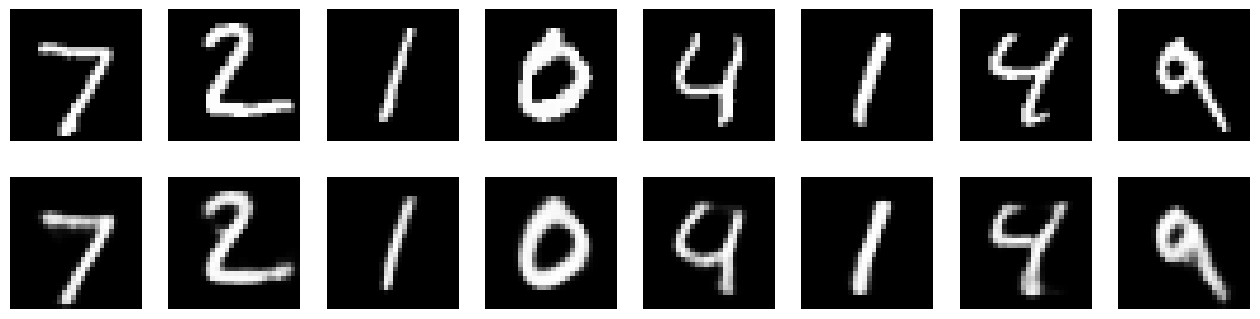

In [19]:
model.eval()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        x_hat, _, _ = model(x)
        break  # only one batch

n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(x[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i+n+1)
    plt.imshow(x_hat[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


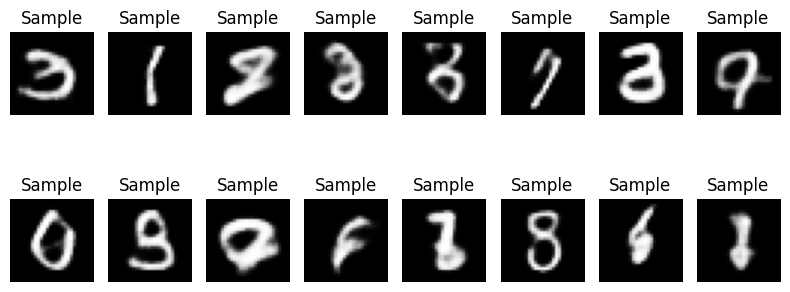

In [23]:
with torch.no_grad():
    z = torch.randn(16, 20).to(device)  # 16 samples, 20-d latent
    generated = model.decode(z).cpu()

# Generated digits
plt.figure(figsize=(8, 4))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    plt.imshow(generated[i].squeeze(), cmap='gray')
    plt.title("Sample")
    plt.axis('off')
plt.tight_layout()
plt.show()
